# Vaex introduction in 11 minutes 

[Because vaex goes up to 11](https://en.wikipedia.org/wiki/Up_to_eleven)

If you want to try out this notebook with a live Python kernel, use mybinder:

<a class="reference external image-reference" href="https://mybinder.org/v2/gh/vaexio/vaex/latest?filepath=docs%2Fsource%2Ftutorial.ipynb"><img alt="https://mybinder.org/badge_logo.svg" src="https://mybinder.org/badge_logo.svg" width="150px"></a>

## DataFrame
Central to Vaex is the DataFrame (similar, but more efficient than a Pandas DataFrame), and we often use the variable `df` to represent it. A DataFrame is an efficient representation for a large tabular dataset, and has:

 * A number of columns, say `x`, `y` and `z`, which are:
   * Backed by a Numpy array;
   * Wrapped by an expression system e.g. `df.x`, `df['x']` or `df.col.x` is an Expression;
   * Columns/expression can perform lazy computations, e.g. `df.x * np.sin(df.y)` does nothing, until the result is needed.
 * A set of virtual columns, columns that are backed by a (lazy) computation, e.g. `df['r'] = df.x/df.y` 
 * A set of selections, that can be used to explore the dataset, e.g. `df.select(df.x < 0)`
 * Filtered DataFrames, that does not copy the data, `df_negative = df[df.x < 0]`
 
Lets start with an example dataset, which is included in Vaex.

In [1]:
import vaex
df = vaex.example()
df  # Since this is the last statement in a cell, it will print the DataFrame in a nice HTML format. 

#,id,x,y,z,vx,vy,vz,E,L,Lz,FeH
0,0,1.2318683862686157,-0.39692866802215576,-0.598057746887207,301.1552734375,174.05947875976562,27.42754554748535,-149431.40625,407.38897705078125,333.9555358886719,-1.0053852796554565
1,23,-0.16370061039924622,3.654221296310425,-0.25490644574165344,-195.00022888183594,170.47216796875,142.5302276611328,-124247.953125,890.2411499023438,684.6676025390625,-1.7086670398712158
2,32,-2.120255947113037,3.326052665710449,1.7078403234481812,-48.63423156738281,171.6472930908203,-2.079437255859375,-138500.546875,372.2410888671875,-202.17617797851562,-1.8336141109466553
3,8,4.7155890464782715,4.5852508544921875,2.2515437602996826,-232.42083740234375,-294.850830078125,62.85865020751953,-60037.0390625,1297.63037109375,-324.6875,-1.4786882400512695
4,16,7.21718692779541,11.99471664428711,-1.064562201499939,-1.6891745328903198,181.329345703125,-11.333610534667969,-83206.84375,1332.7989501953125,1328.948974609375,-1.8570483922958374
...,...,...,...,...,...,...,...,...,...,...,...
"329,995",21,1.9938701391220093,0.789276123046875,0.22205990552902222,-216.92990112304688,16.124420166015625,-211.244384765625,-146457.4375,457.72247314453125,203.36758422851562,-1.7451677322387695
"329,996",25,3.7180912494659424,0.721337616443634,1.6415337324142456,-185.92160034179688,-117.25082397460938,-105.4986572265625,-126627.109375,335.0025634765625,-301.8370056152344,-0.9822322130203247
"329,997",14,0.3688507676124573,13.029608726501465,-3.633934736251831,-53.677146911621094,-145.15771484375,76.70909881591797,-84912.2578125,817.1375732421875,645.8507080078125,-1.7645612955093384
"329,998",18,-0.11259264498949051,1.4529125690460205,2.168952703475952,179.30865478515625,205.79710388183594,-68.75872802734375,-133498.46875,724.000244140625,-283.6910400390625,-1.8808952569961548


### Columns
The above preview shows that this dataset contains $> 300,000$ rows, and columns named x ,y, z (positions), vx, vy, vz (velocities), E (energy), L (angular momentum), and an id (subgroup of samples). When we print out a columns, we can see that it is not a Numpy array, but an Expression.

In [2]:
df.x  # df.col.x or df['x'] are equivalent, but df.x may be preferred because it is more tab completion friendly or programming friendly respectively

Expression = x
Length: 330,000 dtype: float32 (column)
---------------------------------------
     0    1.23187
     1  -0.163701
     2   -2.12026
     3    4.71559
     4    7.21719
       ...       
329995    1.99387
329996    3.71809
329997   0.368851
329998  -0.112593
329999    20.7962

One can use the `.values` method to get an in-memory representation of an expression. The same method can be applied to a DataFrame as well.

In [3]:
df.x.values

array([ 1.2318684 , -0.16370061, -2.120256  , ...,  0.36885077,
       -0.11259264, 20.79622   ], dtype=float32)

Most Numpy functions (ufuncs) can be performed on expressions, and will not result in a direct result, but in a new expression.

In [4]:
import numpy as np
np.sqrt(df.x**2 + df.y**2 + df.z**2)

Expression = sqrt((((x ** 2) + (y ** 2)) + (z ** 2)))
Length: 330,000 dtype: float32 (expression)
-------------------------------------------
     0  1.42574
     1  3.66676
     2  4.29824
     3  6.95203
     4   14.039
      ...      
329995  2.15587
329996  4.12785
329997  13.5319
329998  2.61304
329999  24.3339

### Virtual columns
Sometimes it is convenient to store an expression as a column. We call this a virtual column since it does not take up any memory, and is computed on the fly when needed. A virtual column is treated just as a normal column.

In [5]:
df['r'] = np.sqrt(df.x**2 + df.y**2 + df.z**2)
df[['x', 'y', 'z', 'r']]

#,x,y,z,r
0,1.2318683862686157,-0.39692866802215576,-0.598057746887207,1.425736665725708
1,-0.16370061039924622,3.654221296310425,-0.25490644574165344,3.666757345199585
2,-2.120255947113037,3.326052665710449,1.7078403234481812,4.298235893249512
3,4.7155890464782715,4.5852508544921875,2.2515437602996826,6.952032566070557
4,7.21718692779541,11.99471664428711,-1.064562201499939,14.03902816772461
...,...,...,...,...
"329,995",1.9938701391220093,0.789276123046875,0.22205990552902222,2.155872344970703
"329,996",3.7180912494659424,0.721337616443634,1.6415337324142456,4.127851963043213
"329,997",0.3688507676124573,13.029608726501465,-3.633934736251831,13.531896591186523
"329,998",-0.11259264498949051,1.4529125690460205,2.168952703475952,2.613041877746582


### Selections and filtering
Vaex can be efficient when exploring subsets of the data, for instance to remove outliers or to inspect only a part of the data. Instead of making copies, Vaex internally keeps track which rows are selected.

In [6]:
df.select(df.x < 0)
df.evaluate(df.x, selection=True)

array([-0.16370061, -2.120256  , -7.7843747 , ..., -8.126636  ,
       -3.9477386 , -0.11259264], dtype=float32)

Selections are useful when you frequently modify the portion of the data you want to visualize, or when you want to efficiently compute statistics on several portions of the data effectively.

Alternatively, you can also create filtered datasets. This is similar to using Pandas, except that Vaex does not copy the data.

In [7]:
df_negative = df[df.x < 0]
df_negative[['x', 'y', 'z', 'r']]

#,x,y,z,r
0,-0.16370061039924622,3.654221296310425,-0.25490644574165344,3.666757345199585
1,-2.120255947113037,3.326052665710449,1.7078403234481812,4.298235893249512
2,-7.784374713897705,5.989774703979492,-0.682695209980011,9.845809936523438
3,-3.5571861267089844,5.413629055023193,0.09171556681394577,6.478376865386963
4,-20.813940048217773,-3.294677495956421,13.486607551574707,25.019264221191406
...,...,...,...,...
"166,274",-2.5926425457000732,-2.871671676635742,-0.18048334121704102,3.8730955123901367
"166,275",-0.7566012144088745,2.9830434322357178,-6.940553188323975,7.592250823974609
"166,276",-8.126635551452637,1.1619765758514404,-1.6459038257598877,8.372657775878906
"166,277",-3.9477386474609375,-3.0684902667999268,-1.5822702646255493,5.244411468505859


## Statistics on N-d grids

A core feature of Vaex is the extremely efficient calculation of statistics on N-dimensional grids. The is rather useful for making visualisations of large datasets.

In [8]:
df.count(), df.mean(df.x), df.mean(df.x, selection=True)

(array(330000), array(-0.0632868), array(-5.18457762))

Similar to SQL's groupby, Vaex uses the binby concept, which tells Vaex that a statistic should be calculated on a regular grid (for performance reasons)

In [9]:
counts_x = df.count(binby=df.x, limits=[-10, 10], shape=64)
counts_x

array([1374, 1350, 1459, 1618, 1706, 1762, 1852, 2007, 2240, 2340, 2610,
       2840, 3126, 3337, 3570, 3812, 4216, 4434, 4730, 4975, 5332, 5800,
       6162, 6540, 6805, 7261, 7478, 7642, 7839, 8336, 8736, 8279, 8269,
       8824, 8217, 7978, 7541, 7383, 7116, 6836, 6447, 6220, 5864, 5408,
       4881, 4681, 4337, 4015, 3799, 3531, 3320, 3040, 2866, 2629, 2488,
       2244, 1981, 1905, 1734, 1540, 1437, 1378, 1233, 1186])

This results in a Numpy array with the number counts in 64 bins distributed between x = -10, and x = 10. We can quickly visualize this using Matplotlib.

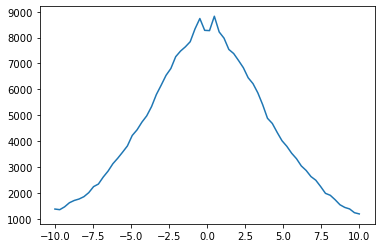

In [10]:
import matplotlib.pylab as plt
plt.plot(np.linspace(-10, 10, 64), counts_x)
plt.show()

We can do the same in 2D as well (this can be generalized to N-D actually!), and display it with Matplotlib.

In [11]:
xycounts = df.count(binby=[df.x, df.y], limits=[[-10, 10], [-10, 20]], shape=(64, 128))
xycounts

array([[ 5,  2,  3, ...,  3,  3,  0],
       [ 8,  4,  2, ...,  5,  3,  2],
       [ 5, 11,  7, ...,  3,  3,  1],
       ...,
       [ 4,  8,  5, ...,  2,  0,  2],
       [10,  6,  7, ...,  1,  1,  2],
       [ 6,  7,  9, ...,  2,  2,  2]])

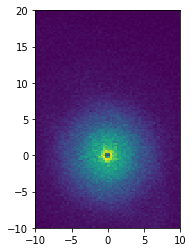

In [12]:
plt.imshow(xycounts.T, origin='lower', extent=[-10, 10, -10, 20])
plt.show()

In [13]:
v = np.sqrt(df.vx**2 + df.vy**2 + df.vz**2)
xy_mean_v = df.mean(v, binby=[df.x, df.y], limits=[[-10, 10], [-10, 20]], shape=(64, 128))
xy_mean_v

array([[156.15283203, 226.0004425 , 206.95940653, ...,  90.0340627 ,
        152.08784485,          nan],
       [203.81366634, 133.01436043, 146.95962524, ..., 137.54756927,
         98.68717448, 141.06020737],
       [150.59178772, 188.38820371, 137.46753802, ..., 155.96900177,
        148.91660563, 138.48191833],
       ...,
       [168.93819809, 187.75943136, 137.318647  , ..., 144.83927917,
                 nan, 107.7273407 ],
       [154.80492783, 140.55182203, 180.30700166, ..., 184.01670837,
         95.10913086, 131.18122864],
       [166.06868235, 150.54079764, 125.84606828, ..., 130.56007385,
        121.04217911, 113.34659195]])

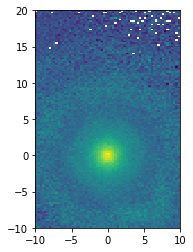

In [14]:
plt.imshow(xy_mean_v.T, origin='lower', extent=[-10, 10, -10, 20])
plt.show()

Other statistics can be computed, such as:

* [DataFrame.count](api.rst#vaex.dataframe.DataFrame.count)
* [DataFrame.mean](api.rst#vaex.dataframe.DataFrame.mean)
* [DataFrame.std](api.rst#vaex.dataframe.DataFrame.std)
* [DataFrame.var](api.rst#vaex.dataframe.DataFrame.var)
* [DataFrame.median_approx](api.rst#vaex.dataframe.DataFrame.median_approx)
* [DataFrame.percentile_approx](api.rst#vaex.dataframe.DataFrame.percentile_approx)
* [DataFrame.mode](api.rst#vaex.dataframe.DataFrame.mode)
* [DataFrame.min](api.rst#vaex.dataframe.DataFrame.min)
* [DataFrame.max](api.rst#vaex.dataframe.DataFrame.max)
* [DataFrame.minmax](api.rst#vaex.dataframe.DataFrame.minmax)
* [DataFrame.mutual_information](api.rst#vaex.dataframe.DataFrame.mutual_information)
* [DataFrame.correlation](api.rst#vaex.dataframe.DataFrame.correlation)

Or see the full list at the [API docs](api.rst#statistics).

## Getting your data in

Before continuing with this tutorial, you may want to read in your own data. Ultimately, a Vaex DataFrame just wraps a set of Numpy arrays. If you can access your data as a set of Numpy arrays, you can easily construct a DataFrame using [from_arrays](api.rst#vaex.from_arrays).

In [15]:
import vaex
import numpy as np
x = np.arange(5)
y = x**2
df = vaex.from_arrays(x=x, y=y)
df

#,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16


Other quick ways to get your data in are:
 
  * [from_arrow_table](api.rst#vaex.from_arrow_table): [Arrow](https://arrow.apache.org/) table support
  * [from_csv](api.rst#vaex.from_csv): Comma separated files
  * [from_ascii](api.rst#vaex.from_ascii): Space/tab separated files
  * [from_pandas](api.rst#vaex.from_pandas): Converts a pandas DataFrame
  * [from_astropy_table](api.rst#vaex.from_astropy_table): Converts an astropy table

Exporting, or converting a DataFrame to a different datastructure is also quite easy:
 
 * [DataFrame.to_arrow_table](api.rst#vaex.dataframe.DataFrame.to_arrow_table)
 * [DataFrame.to_dask_array](api.rst#vaex.dataframe.DataFrame.to_dask_array) 
 * [DataFrame.to_pandas_df](api.rst#vaex.dataframe.DataFrame.to_pandas_df)
 * [DataFrame.export](api.rst#vaex.dataframe.DataFrameLocal.export)
 * [DataFrame.export_hdf5](api.rst#vaex.dataframe.DataFrameLocal.export_hdf5)
 * [DataFrame.export_arrow](api.rst#vaex.dataframe.DataFrameLocal.export_arrow)
 * [DataFrame.export_fits](api.rst#vaex.dataframe.DataFrameLocal.export_fits)
 

Nowadays, it is common to put data, especially larger dataset, on the cloud. Vaex can read data straight from S3, in a lazy manner, meaning that only that data that is needed will be downloaded, and cached on disk.

In [16]:
# Read in the NYC Taxi dataset straight from S3
nyctaxi = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')
nyctaxi.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.35,-74.0026,40.7397,nan,nan,-73.87,40.7702,23.7,0,nan,4.74,0,28.44
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7


## Plotting

### 1-D and 2-D

Most visualizations are done in 1 or 2 dimensions, and Vaex nicely wraps Matplotlib to satisfy a variety of frequent use cases.


In [17]:
import vaex
import numpy as np
df = vaex.example()

The simplest visualization is a 1-D plot using [DataFrame.plot1d](api.rst#vaex.dataframe.DataFrame.plot1d). When only given one argument, it will show a histogram showing 99.7% of the data.

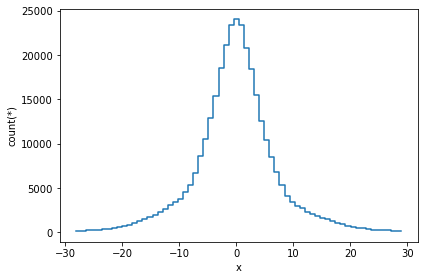

In [18]:
df.plot1d(df.x, limits='99.7%');

A slighly more complication visualization, is to plot not the counts, but a different statistic for that bin. In most 
cases, passing the `what='<statistic>(<expression>)` argument will do, where `<statistic>` is any of the statistics mentioned in the list above, or in the [API docs](api.rst#statistics).

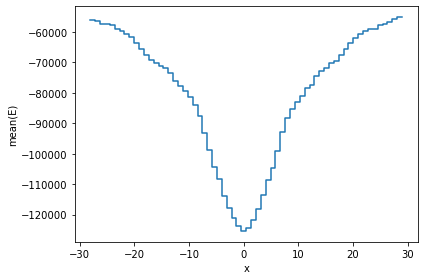

In [19]:
df.plot1d(df.x, what='mean(E)', limits='99.7%');

An equivalent method is to use the `vaex.stat.<statistic>` functions, e.g. [vaex.stat.mean](api.rst#vaex.stat.mean).

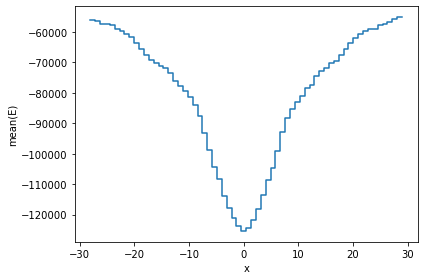

In [20]:
df.plot1d(df.x, what=vaex.stat.mean(df.E), limits='99.7%');

The `vaex.stat.<statistic>` objects are very similar to Vaex expressions, in that they represent an underlying calculation. Typical arithmetic and Numpy functions can be applied to these calulations. However, these objects compute a single statistic, and do not return a column or expression.

In [21]:
np.log(vaex.stat.mean(df.x)/vaex.stat.std(df.x))

log((mean(x) / std(x)))

These statistical objects can be passed to the `what` argument. The advantage being that the data will only have to be passed over once.

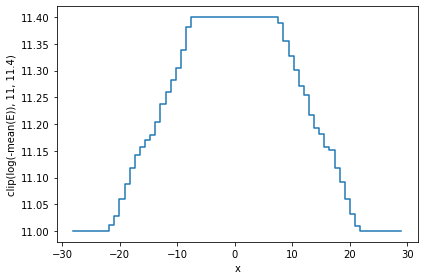

In [22]:
df.plot1d(df.x, what=np.clip(np.log(-vaex.stat.mean(df.E)), 11, 11.4), limits='99.7%');

A similar result can be obtained by calculating the statistic ourselves, and passing it to plot1d's grid argument. Care has to be taken that the limits used for calculating the statistics and the plot are the same, otherwise the x axis may not correspond to the real data.

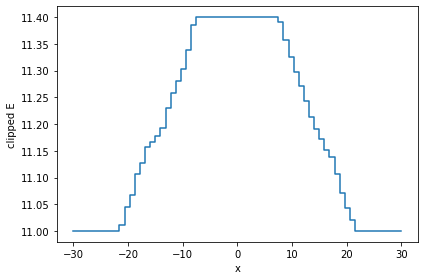

In [23]:
limits = [-30, 30]
shape  = 64
meanE  = df.mean(df.E, binby=df.x, limits=limits, shape=shape)
grid   = np.clip(np.log(-meanE), 11, 11.4)
df.plot1d(df.x, grid=grid, limits=limits, ylabel='clipped E');

The same applies for 2-D plotting.

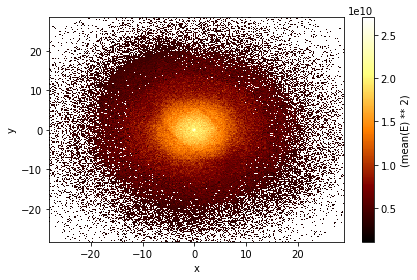

In [24]:
df.plot(df.x, df.y, what=vaex.stat.mean(df.E)**2, limits='99.7%');

### Selections for plotting

While filtering is useful for narrowing down the contents of a DataFrame (e.g. `df_negative = df[df.x < 0]`) there are a few downsides to this. First, a practical issue is that when you filter 4 different ways, you will need to have 4 different DataFrames polluting your namespace. More importantly, when Vaex executes a bunch of statistical computations, it will do that per DataFrame, meaning that 4 passes over the data will be made, and even though all 4 of those DataFrames point to the same underlying data.

If instead we have 4 (named) selections in our DataFrame, we can calculate statistics in one single pass over the data, which can be significantly faster especially in the cases when your dataset is larger than your memory.

In the plot below we show three selection, which by default are blended together, requiring just one pass over the data.

/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/image.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgba_dest[:, :, c][[mask]] = np.clip(result[[mask]], 0, 1)


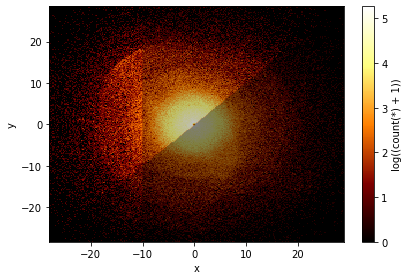

In [25]:
df.plot(df.x, df.y, what=np.log(vaex.stat.count()+1), limits='99.7%',
        selection=[None, df.x < df.y, df.x < -10]);

### Advanced Plotting
Lets say we would like to see two plots next to eachother. To achieve this we can pass a list of expression pairs.

/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/viz/mpl.py:779: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pylab.subplot(gs[row_offset + row * row_scale:row_offset + (row + 1) * row_scale, column * column_scale:(column + 1) * column_scale])


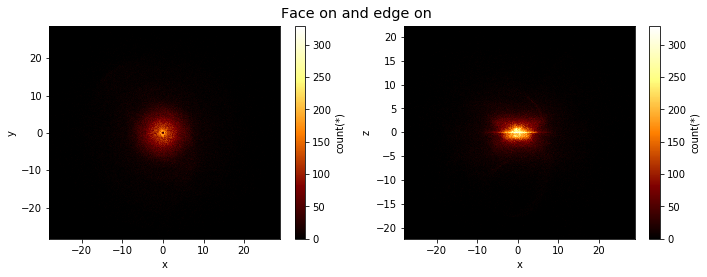

In [26]:
df.plot([["x", "y"], ["x", "z"]], limits='99.7%',
        title="Face on and edge on", figsize=(10,4));

By default, if you have multiple plots, they are shown as columns, multiple selections are overplotted, and multiple 'whats' (statistics) are shown as rows.

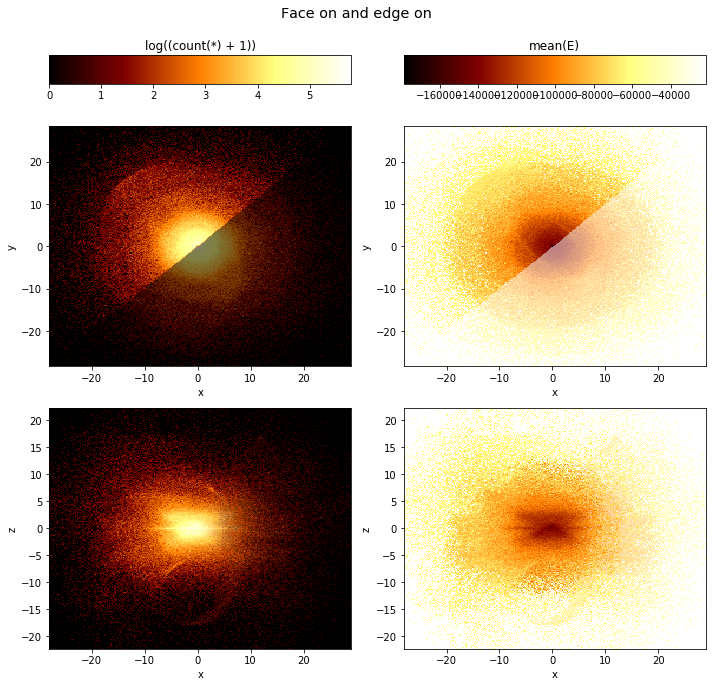

In [27]:
df.plot([["x", "y"], ["x", "z"]], 
        limits='99.7%',
        what=[np.log(vaex.stat.count()+1), vaex.stat.mean(df.E)],
        selection=[None, df.x < df.y],
        title="Face on and edge on", figsize=(10,10));

Note that the selection has no effect in the bottom rows.

However, this behaviour can be changed using the `visual` argument.

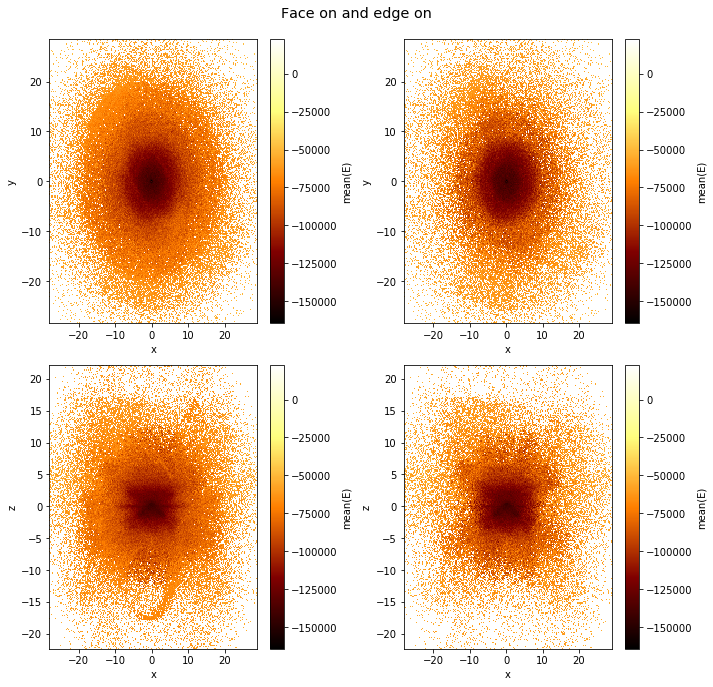

In [28]:
df.plot([["x", "y"], ["x", "z"]],
        limits='99.7%',
        what=vaex.stat.mean(df.E),
        selection=[None, df.Lz < 0],
        visual=dict(column='selection'),
        title="Face on and edge on", figsize=(10,10));

### Slices in a 3rd dimension
If a 3rd axis (z) is given, you can 'slice' through the data, displaying the z slices as rows. Note that here the rows are wrapped, which can be changed using the `wrap_columns` argument.

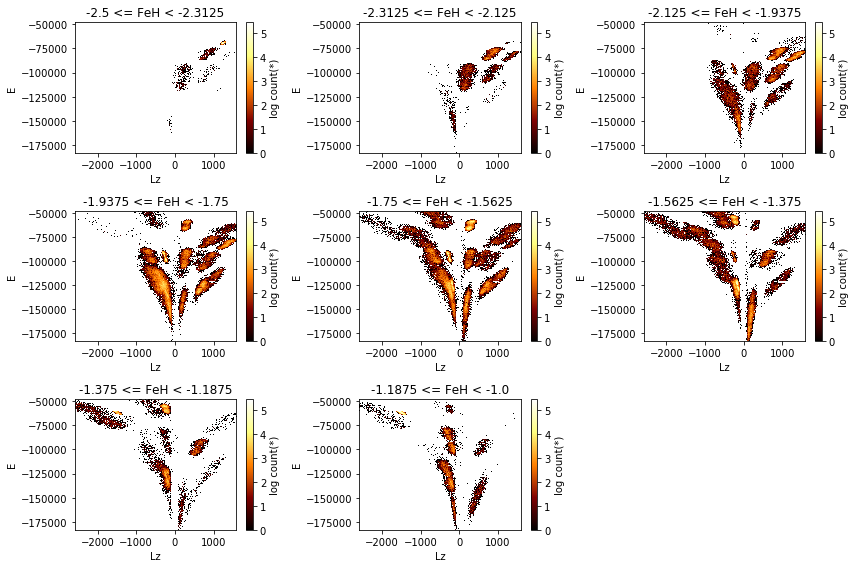

In [29]:
df.plot("Lz", "E", 
        limits='99.7%',
        z="FeH:-2.5,-1,8", show=True, visual=dict(row="z"),
        figsize=(12,8), f="log", wrap_columns=3);

### Visualization of smaller datasets

Although Vaex focuses on large datasets, sometimes you end up with a fraction of the data (e.g. due to a selection) and you want to make a scatter plot. You can do so with the following approach:

In [30]:
import vaex
df = vaex.example()

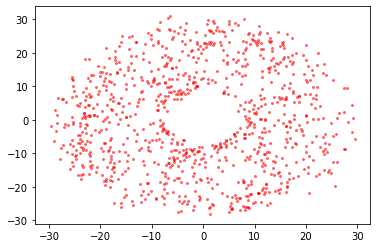

In [31]:
import matplotlib.pylab as plt
x = df.evaluate("x", selection=df.Lz < -2500)
y = df.evaluate("y", selection=df.Lz < -2500)
plt.scatter(x, y, c="red", alpha=0.5, s=4);

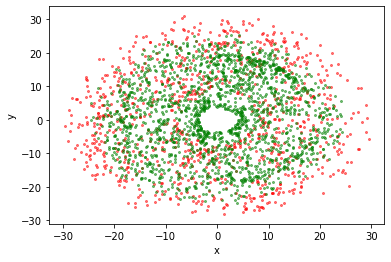

In [32]:
df.scatter(df.x, df.y, selection=df.Lz < -2500, c="red", alpha=0.5, s=4)
df.scatter(df.x, df.y, selection=df.Lz > 1500, c="green", alpha=0.5, s=4);

### In control

While Vaex provides a wrapper for Matplotlib, there are situations where you want to use the [DataFrame.plot](api.rst#vaex.dataframe.DataFrame.plot) method, but want to be in control of the plot. Vaex simply uses the current figure and axes objects, so that it is easy to do.

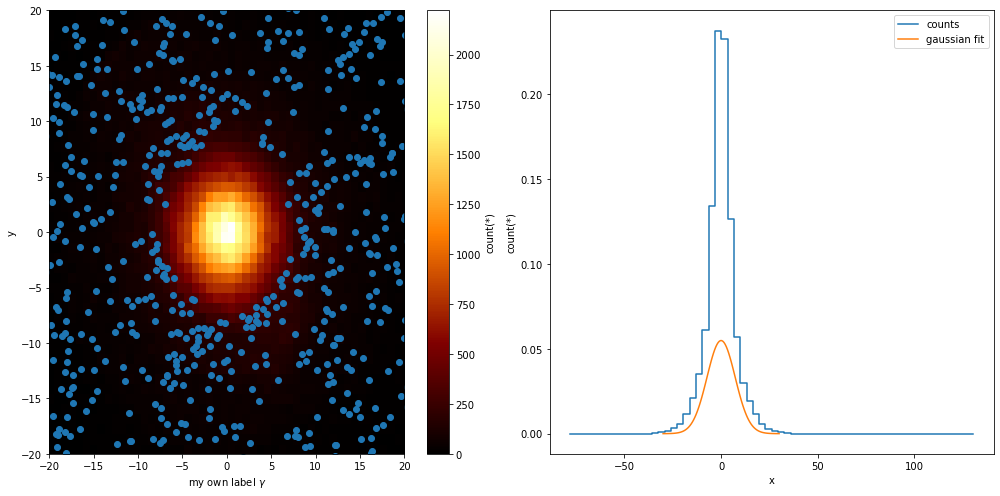

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
plt.sca(ax1)
selection = df.Lz < -2500
x = df[selection].x.evaluate()#selection=selection)
y = df[selection].y.evaluate()#selection=selection)
df.plot(df.x, df.y)
plt.scatter(x, y)
plt.xlabel('my own label $\gamma$')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

plt.sca(ax2)
df.plot1d(df.x, label='counts', n=True)
x = np.linspace(-30, 30, 100)
std = df.std(df.x.expression)
y = np.exp(-(x**2/std**2/2)) / np.sqrt(2*np.pi) / std
plt.plot(x, y, label='gaussian fit')
plt.legend()
plt.show()

### Healpix (Plotting)
[Healpix](https://en.wikipedia.org/wiki/HEALPix) plotting is supported via the [healpy](https://healpy.readthedocs.io) package. Vaex does not need special support for healpix, only for plotting, but some helper functions are introduced to make working with healpix easier. 

In the following example we will use the TGAS astronomy dataset.
 
To understand healpix better, we will start from the beginning. If we want to make a density sky plot, we would like to pass healpy a 1D Numpy array where each value represents the density at a location of the sphere, where the location is determined by the array size (the healpix level) and the offset (the location). The TGAS (and Gaia) data includes the healpix index encoded in the `source_id`. By diving the `source_id` by 34359738368 you get a healpix index level 12, and diving it further will take you to lower levels.



In [34]:
import vaex
import healpy as hp
tgas = vaex.datasets.tgas.fetch()

We will start showing how you could manually do statistics on healpix bins using `vaex.count`. We will do a really course healpix scheme (level 2).

In [35]:
level = 2
factor = 34359738368 * (4**(12-level))
nmax = hp.nside2npix(2**level)
epsilon = 1e-16
counts = tgas.count(binby=tgas.source_id/factor, limits=[-epsilon, nmax-epsilon], shape=nmax)
counts

array([ 4021,  6171,  5318,  7114,  5755, 13420, 12711, 10193,  7782,
       14187, 12578, 22038, 17313, 13064, 17298, 11887,  3859,  3488,
        9036,  5533,  4007,  3899,  4884,  5664, 10741,  7678, 12092,
       10182,  6652,  6793, 10117,  9614,  3727,  5849,  4028,  5505,
        8462, 10059,  6581,  8282,  4757,  5116,  4578,  5452,  6023,
        8340,  6440,  8623,  7308,  6197, 21271, 23176, 12975, 17138,
       26783, 30575, 31931, 29697, 17986, 16987, 19802, 15632, 14273,
       10594,  4807,  4551,  4028,  4357,  4067,  4206,  3505,  4137,
        3311,  3582,  3586,  4218,  4529,  4360,  6767,  7579, 14462,
       24291, 10638, 11250, 29619,  9678, 23322, 18205,  7625,  9891,
        5423,  5808, 14438, 17251,  7833, 15226,  7123,  3708,  6135,
        4110,  3587,  3222,  3074,  3941,  3846,  3402,  3564,  3425,
        4125,  4026,  3689,  4084, 16617, 13577,  6911,  4837, 13553,
       10074,  9534, 20824,  4976,  6707,  5396,  8366, 13494, 19766,
       11012, 16130,

And using healpy's [mollview](https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.mollview.html#healpy.visufunc.mollview) we can visualize this.

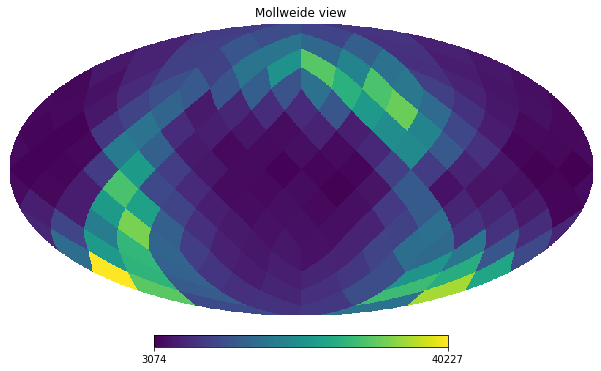

In [36]:
hp.mollview(counts, nest=True)

To simplify life, Vaex includes [DataFrame.healpix_count](api.rst#vaex.dataframe.DataFrame.healpix_count) to take care of this.

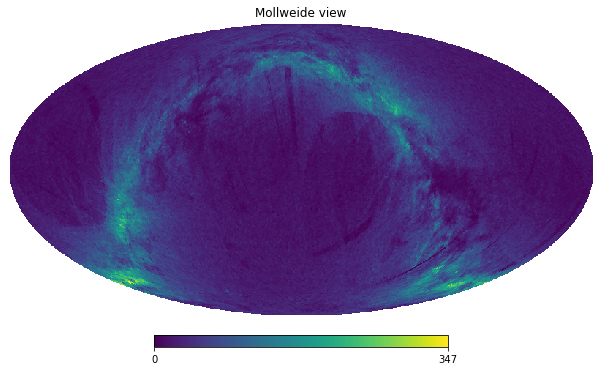

In [37]:
counts = tgas.healpix_count(healpix_level=6)
hp.mollview(counts, nest=True)

Or even simpler, use [DataFrame.healpix_plot](api.rst#vaex.dataframe.DataFrame.healpix_plot)

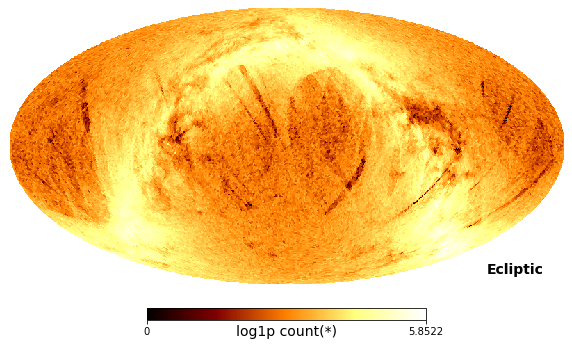

In [38]:
tgas.healpix_plot(f="log1p", healpix_level=6, figsize=(10,8),
                  healpix_output="ecliptic")

## [xarray](http://xarray.pydata.org) suppport

The `df.count` method can also return an [xarray](http://xarray.pydata.org) data array instead of a numpy array. This is easily done via the `array_type` keyword. Building on top of numpy, xarray adds dimension labels, coordinates and attributes, that makes working with multi-dimensional arrays more convenient. 

In [39]:
xarr = df.count(binby=[df.x, df.y], limits=[-10, 10], shape=64, array_type='xarray')
xarr

<xarray.DataArray (x: 64, y: 64)>
array([[ 6,  3,  7, ..., 15, 10, 11],
       [10,  3,  7, ..., 10, 13, 11],
       [ 5, 15,  5, ..., 12, 18, 12],
       ...,
       [ 7,  8, 10, ...,  6,  7,  7],
       [12, 10, 17, ..., 11,  8,  2],
       [ 7, 10, 13, ...,  6,  5,  7]])
Coordinates:
  * x        (x) float64 -9.844 -9.531 -9.219 -8.906 ... 8.906 9.219 9.531 9.844
  * y        (y) float64 -9.844 -9.531 -9.219 -8.906 ... 8.906 9.219 9.531 9.844

In addition, xarray also has a plotting method that can be quite convenient. Since the xarray object has information about the labels of each dimension, the plot axis will be automatially labeled.

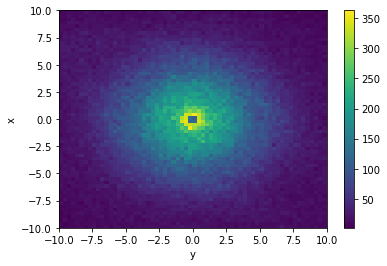

In [40]:
xarr.plot();

Having xarray as output helps us to explore the contents of our data faster. In the following example we show how easy it is to plot the 2D distribution of the positions of the samples (x, y), per id group.

Notice how xarray automatically adds the appropriate titles and axis labels to the figure.

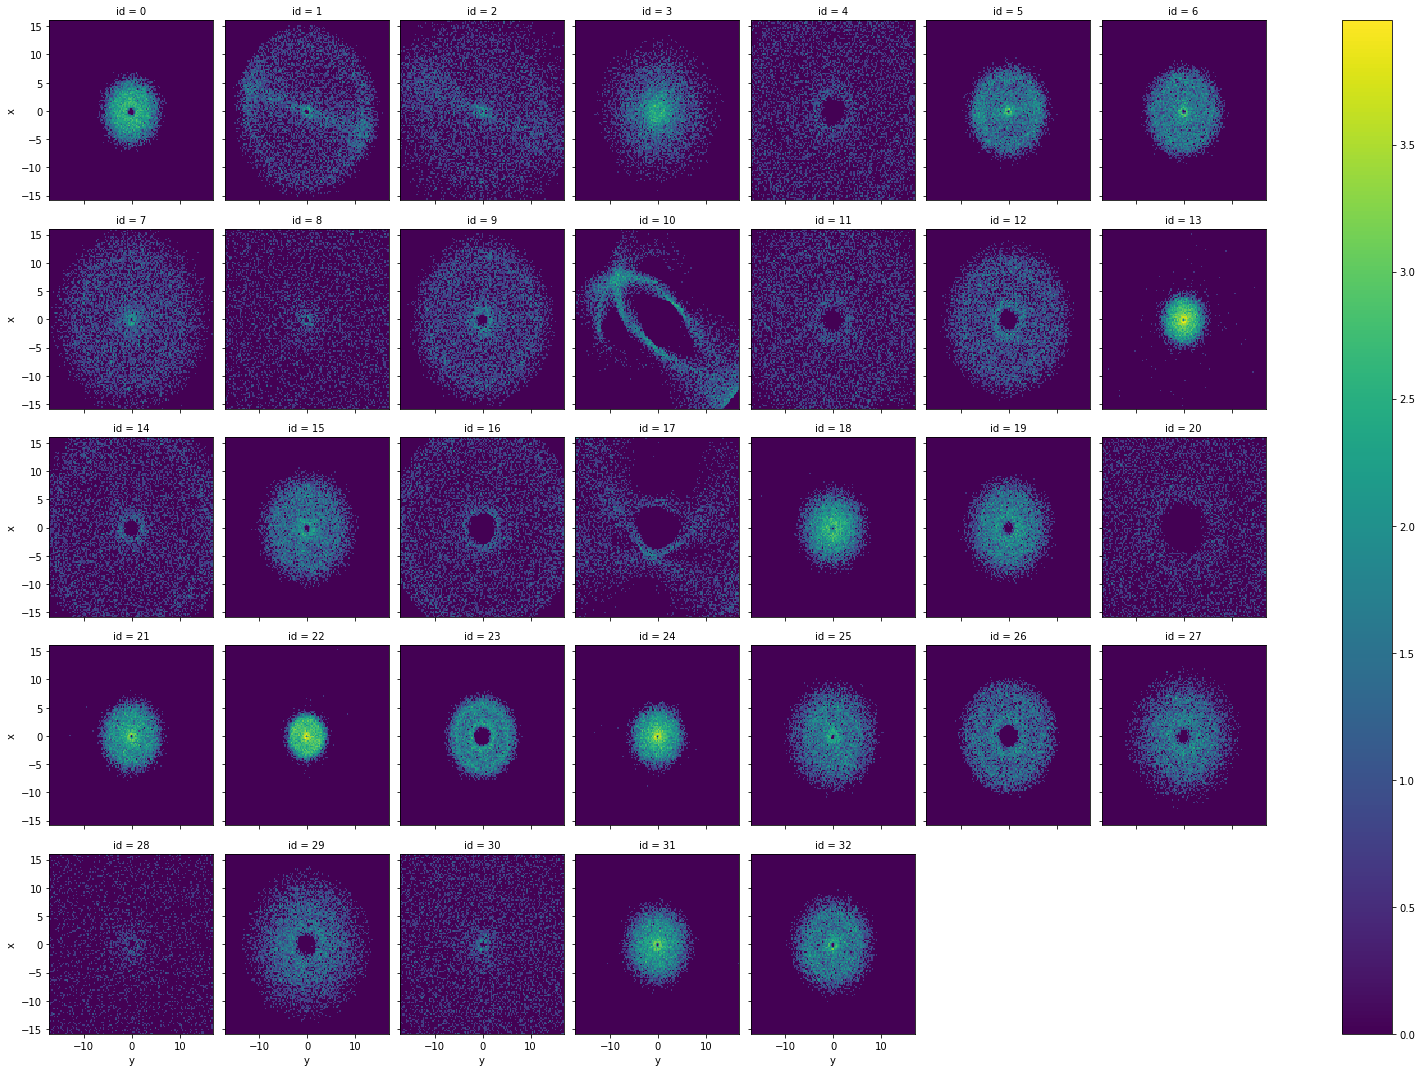

In [41]:
df.categorize('id', inplace=True)  # treat the id as a categorical column - automatically adjusts limits and shape
xarr = df.count(binby=['x', 'y', 'id'], limits='95%', array_type='xarray')
np.log1p(xarr).plot(col='id', col_wrap=7);

## Interactive widgets

<div class="alert alert-info">

**Note:** The interactive widgets require a running Python kernel, if you are viewing this documentation online you can get a feeling for what the widgets can do, but computation will not be possible!

</div>

Using the `vaex-jupyter` package, we get access to interactive widgets (go see the [Vaex Jupyter tutorial](tutorial_jupyter.ipynb) for a more in depth tutorial)

In [42]:
import vaex
import vaex.jupyter
import numpy as np
import pylab as plt
df = vaex.example()

The simplest way to get a more interactive visualization (or even print out statistics) is to use the `vaex.jupyter.interactive_selection` decorator, which will execute the decorated function each time the selection is changed.


In [43]:
df.select(df.x > 0)
@vaex.jupyter.interactive_selection(df)
def plot(*args, **kwargs):
    print("Mean x for the selection is:", df.mean(df.x, selection=True))
    df.plot(df.x, df.y, what=np.log(vaex.stat.count()+1), selection=[None, True], limits='99.7%')
    plt.show()

Output()

After changing the selection programmatically, the visualization will update, as well as the print output.

In [44]:
df.select(df.x > df.y)

However, to get truly interactive visualization, we need to use widgets, such as the [bqplot](https://github.com/bloomberg/bqplot) library. Again, if we make a selection here, the above visualization will also update, so lets select a square region.

See more interactive widgets in the [Vaex Jupyter tutorial](tutorial_jupyter.ipynb)

## Joining

Joining in Vaex is similar to Pandas, except the data will no be copied. Internally an index array is kept for each row on the left DataFrame, pointing to the right DataFrame, requiring about 8GB for a billion row $10^9$ dataset.
Lets start with 2 small DataFrames, `df1` and `df2`:

In [47]:
a = np.array(['a', 'b', 'c'])
x = np.arange(1,4)
df1 = vaex.from_arrays(a=a, x=x)
df1

#,a,x
0,a,1
1,b,2
2,c,3


In [48]:
b = np.array(['a', 'b', 'd'])
y = x**2
df2 = vaex.from_arrays(b=b, y=y)
df2

#,b,y
0,a,1
1,b,4
2,d,9


The default join, is a 'left' join, where all rows for the left DataFrame (`df1`) are kept, and matching rows of the right DataFrame (`df2`) are added. We see that for the columns b and y, some values are missing, as expected.

In [49]:
df1.join(df2, left_on='a', right_on='b')

#,a,x,b,y
0,a,1,a,1
1,b,2,b,4
2,c,3,--,--


A 'right' join, is basically the same, but now the roles of the left and right label swapped, so now we have some values from columns x and a missing.

In [50]:
df1.join(df2, left_on='a', right_on='b', how='right')

#,b,y,a,x
0,a,1,a,1
1,b,4,b,2
2,d,9,--,--


We can also do 'inner' join, in which the output DataFrame has only the rows common between `df1` and `df2`.

In [51]:
df1.join(df2, left_on='a', right_on='b', how='inner')

#,a,x,b,y
0,a,1,a,1
1,b,2,b,4


Other joins (e.g. outer) are currently not supported. Feel free to [open an issue on GitHub](https://github.com/vaexio/vaex/issues) for this.

## Group-by

With Vaex one can also do fast group-by aggregations. The output is Vaex DataFrame. Let us see few examples.

In [52]:
import vaex
animal = ['dog', 'dog', 'cat', 'guinea pig', 'guinea pig', 'dog']
age = [2, 1, 5, 1, 3, 7]
cuteness = [9, 10, 5, 8, 4, 8]
df_pets = vaex.from_arrays(animal=animal, age=age, cuteness=cuteness)
df_pets

#,animal,age,cuteness
0,dog,2,9
1,dog,1,10
2,cat,5,5
3,guinea pig,1,8
4,guinea pig,3,4
5,dog,7,8


The syntax for doing group-by operations is virtually identical to that of Pandas. Note that when multiple aggregations are passed to a single column or expression, the output colums are appropriately named.

In [53]:
df_pets.groupby(by='animal').agg({'age': 'mean',
                                  'cuteness': ['mean', 'std']})

#,animal,age,cuteness_mean,cuteness_std
0,dog,3.33333,9,0.816497
1,cat,5,5,0
2,guinea pig,2,6,2


Vaex supports a number of aggregation functions:

  * [vaex.agg.count](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.count): Number of elements in a group
  * [vaex.agg.first](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.first): The first element in a group
  * [vaex.agg.max](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.max): The largest value in a group
  * [vaex.agg.min](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.min): The smallest value in a group
  * [vaex.agg.sum](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.sum): The sum of a group
  * [vaex.agg.mean](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.mean): The mean value of a group
  * [vaex.agg.std](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.std): The standard deviation of a group
  * [vaex.agg.var](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.var): The variance of a group
  * [vaex.agg.nunique](https://vaex.readthedocs.io/en/latest/api.html#vaex.agg.nunique): Number of unique elements in a group

In addition, we can specify the aggregation operations inside the groupby-method. Also we can name the resulting aggregate columns as we wish. 

In [54]:
df_pets.groupby(by='animal', 
                agg={'mean_age': vaex.agg.mean('age'),
                     'cuteness_unique_values': vaex.agg.nunique('cuteness'),
                     'cuteness_unique_min': vaex.agg.min('cuteness')})

#,animal,mean_age,cuteness_unique_values,cuteness_unique_min
0,dog,3.33333,3,8
1,cat,5,1,5
2,guinea pig,2,2,4


A powerful feature of the aggregation functions in Vaex is that they support selections. This gives us the flexibility to make selections while aggregating. For example, let's calculate the mean cuteness of the pets in this example DataFrame, but separated by age.

In [55]:
df_pets.groupby(by='animal', 
                agg={'mean_cuteness_old': vaex.agg.mean('cuteness', selection='age>=5'),
                     'mean_cuteness_young': vaex.agg.mean('cuteness', selection='~(age>=5)')})
                           

#,animal,mean_cuteness_old,mean_cuteness_young
0,dog,8,9.5
1,cat,5,nan
2,guinea pig,nan,6


Note that in the last example, the grouped DataFrame contains NaNs for the groups in which there are no samples.

## String processing
String processing is similar to Pandas, except all operations are performed lazily, multithreaded, and faster (in C++). Check the [API docs](api.rst#string-operations) for more examples.

In [56]:
import vaex
text = ['Something', 'very pretty', 'is coming', 'our', 'way.']
df = vaex.from_arrays(text=text)
df

#,text
0,Something
1,very pretty
2,is coming
3,our
4,way.


In [57]:
df.text.str.upper()

Expression = str_upper(text)
Length: 5 dtype: str (expression)
---------------------------------
0    SOMETHING
1  VERY PRETTY
2    IS COMING
3          OUR
4         WAY.

In [58]:
df.text.str.title().str.replace('et', 'ET')

Expression = str_replace(str_title(text), 'et', 'ET')
Length: 5 dtype: str (expression)
---------------------------------
0    SomEThing
1  Very PrETty
2    Is Coming
3          Our
4         Way.

In [59]:
df.text.str.contains('e')

Expression = str_contains(text, 'e')
Length: 5 dtype: bool (expression)
----------------------------------
0   True
1   True
2  False
3  False
4  False

In [60]:
df.text.str.count('e')

Expression = str_count(text, 'e')
Length: 5 dtype: int64 (expression)
-----------------------------------
0  1
1  2
2  0
3  0
4  0

## Propagation of uncertainties

In science one often deals with measurement uncertainties (sometimes refererred to as measurement errors). When transformations are made with quantities that have uncertainties associated with them, the uncertainties on these transformed quantities can be calculated automatically by Vaex. Note that propagation of uncertainties requires derivatives and matrix multiplications of lengthy equations, which is not complex, but tedious. Vaex can automatically calculate all dependencies, derivatives and compute the full covariance matrix.

As an example, let us use the TGAS astronomy dataset once again. Even though the TGAS dataset already contains galactic sky coordiantes (l and b), let's add them again by performing a coordinate system rotation from RA. and Dec.
We can apply a similar transformation and convert from the Sperical galactic to Cartesian coordinates.

In [61]:
# convert parallas to distance
tgas.add_virtual_columns_distance_from_parallax(tgas.parallax)
# 'overwrite' the real columns 'l' and 'b' with virtual columns
tgas.add_virtual_columns_eq2gal('ra', 'dec', 'l', 'b')
# and combined with the galactic sky coordinates gives galactic cartesian coordinates of the stars
tgas.add_virtual_columns_spherical_to_cartesian(tgas.l, tgas.b, tgas.distance, 'x', 'y', 'z')

#,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_n_bad_obs_ac,astrometric_n_bad_obs_al,astrometric_n_good_obs_ac,astrometric_n_good_obs_al,astrometric_n_obs_ac,astrometric_n_obs_al,astrometric_primary_flag,astrometric_priors_used,astrometric_relegation_factor,astrometric_weight_ac,astrometric_weight_al,b,dec,dec_error,dec_parallax_corr,dec_pmdec_corr,dec_pmra_corr,duplicated_source,ecl_lat,ecl_lon,hip,l,matched_observations,parallax,parallax_error,parallax_pmdec_corr,parallax_pmra_corr,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_g_n_obs,phot_variable_flag,pmdec,pmdec_error,pmra,pmra_error,pmra_pmdec_corr,ra,ra_dec_corr,ra_error,ra_parallax_corr,ra_pmdec_corr,ra_pmra_corr,random_index,ref_epoch,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,solution_id,source_id,tycho2_id,distance,x,y,z
0,1.9190566539764404,0.7171010000916003,412.6059727233687,1,0,78,79,79,79,84,3,2.9360971450805664,1.2669624084082898e-05,1.818157434463501,-16.121042828114014,0.23539164875137225,0.21880220693566088,-0.4073381721973419,0.06065881997346878,-0.09945132583379745,70,-16.121052173353853,42.64182504417002,13989,42.641804308626725,9,6.35295075173405,0.3079103606852086,-0.10195717215538025,-0.0015767893055453897,10312332.172993332,10577.365273118843,7.991377829505826,77,b'NOT_AVAILABLE',-7.641989988351149,0.08740179334554747,43.75231341609215,0.07054220642640081,0.21467718482017517,45.03433035439128,-0.41497212648391724,0.30598928200282727,0.17996619641780853,-0.08575969189405441,0.15920649468898773,243619,2015.0,-113.76032257080078,21.39291763305664,-41.67839813232422,26.201841354370117,0.3823484778404236,0.5382660627365112,0.3923785090446472,0.9163063168525696,1635378410781933568,7627862074752,b'',0.15740717016058217,0.11123604040005637,0.10243667003803988,-0.04370685490397632
1,nan,0.2534628812968044,47.316290890180255,2,0,55,57,57,57,84,5,2.6523141860961914,3.1600175134371966e-05,12.861557006835938,-16.19302376369384,0.2000676896877873,1.1977893944215496,0.8376259803771973,-0.9756439924240112,0.9725773334503174,70,-16.19303311057312,42.761180489478576,-2147483648,42.76115974936648,8,3.90032893506844,0.3234880030045522,-0.8537789583206177,0.8397389650344849,949564.6488279914,1140.173576223928,10.580958718900256,62,b'NOT_AVAILABLE',-55.10917285969142,2.522928801165149,10.03626300124532,4.611413518289133,-0.9963987469673157,45.1650067708984,-0.9959233403205872,2.583882288511597,-0.8609106540679932,0.9734798669815063,-0.9724165201187134,487238,2015.0,-156.432861328125,22.76607322692871,-36.23965835571289,22.890602111816406,0.7110026478767395,0.9659702777862549,0.6461148858070374,0.8671600818634033,1635378410781933568,9277129363072,b'55-28-1',0.25638863199686845,0.1807701962996959,0.16716755815017084,-0.07150016957395491
2,nan,0.3989006354041912,221.18496561724646,4,1,57,60,61,61,84,5,3.9934017658233643,2.5633918994572014e-05,5.767529487609863,-16.12335382439265,0.24882543945301736,0.1803264123376257,-0.39189115166664124,-0.19325552880764008,0.08942046016454697,70,-16.123363170402296,42.69750168007008,-2147483648,42.69748094193635,7,3.1553132200367373,0.2734838183180671,-0.11855248361825943,-0.0418587327003479,817837.6000768564,1827.3836759985832,10.743102380434273,60,b'NOT_AVAILABLE',-1.602867102186794,1.0352589283446592,2.9322836829569003,1.908644426623371,-0.9142706990242004,45.08615483797584,-0.1774432212114334,0.2138361631952843,0.30772241950035095,-0.1848166137933731,0.04686680808663368,1948952,2015.0,-117.00751495361328,19.772153854370117,-43.108219146728516,26.7157039642334,0.4825277626514435,0.4287584722042084,0.5241528153419495,0.9030616879463196,1635378410781933568,13297218905216,b'55-1191-1',0.31692574722846595,0.22376103019475546,0.2064625216744117,-0.08801225918215205
3,nan,0.4224923646481251,179.98201436339852,1,0,51,52,52,52,84,5,4.2

Since RA. and Dec. are in degrees, while ra_error and dec_error are in miliarcseconds, we need put them on the same scale

In [62]:
tgas['ra_error'] = tgas.ra_error / 1000 / 3600
tgas['dec_error'] = tgas.dec_error / 1000 / 3600

We now let Vaex sort out what the covariance matrix is for the Cartesian coordinates x, y, and z. Then take 50 samples from the dataset for visualization.

In [63]:
tgas.propagate_uncertainties([tgas.x, tgas.y, tgas.z])
tgas_50 = tgas.sample(50, random_state=42)

For this small subset of the dataset we can visualize the uncertainties, with and without the covariance.

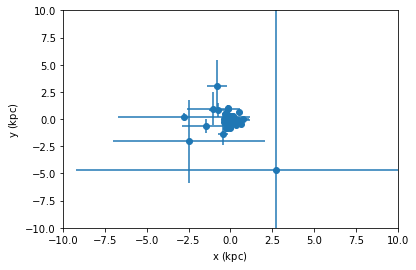

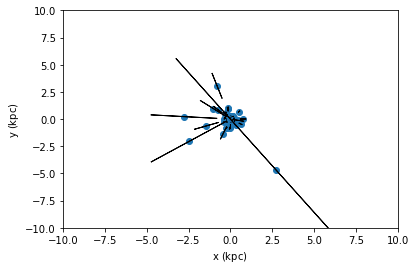

In [64]:
tgas_50.scatter(tgas_50.x, tgas_50.y, xerr=tgas_50.x_uncertainty, yerr=tgas_50.y_uncertainty)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()
tgas_50.scatter(tgas_50.x, tgas_50.y, xerr=tgas_50.x_uncertainty, yerr=tgas_50.y_uncertainty, cov=tgas_50.y_x_covariance)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

From the second plot, we see that showing error ellipses (so narrow that they appear as lines) instead of error bars reveal that the distance information dominates the uncertainty in this case.

## Just-In-Time compilation

Let us start with a function that calculates the angular distance between two points on a surface of a sphere. The input of the function is a pair of 2 angular coordinates, in radians. 

In [65]:
import vaex
import numpy as np
# From http://pythonhosted.org/pythran/MANUAL.html
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    """
    Calculates the pairwise arc distance
    between all points in vector a and b.
    """
    temp = (np.sin((theta_2-2-theta_1)/2)**2
           + np.cos(theta_1)*np.cos(theta_2) * np.sin((phi_2-phi_1)/2)**2)
    distance_matrix = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance_matrix


Let us use the New York Taxi dataset of 2015, [as can be downloaded in hdf5 format](datasets.ipynb#New-york-taxi-dataset)

In [66]:
# nytaxi = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')
nytaxi = vaex.open('/Users/jovan/Work/vaex-work/vaex-taxi/data/yellow_taxi_2009_2015_f32.hdf5')
# lets use just 20% of the data, since we want to make sure it fits
# into memory (so we don't measure just hdd/ssd speed)
nytaxi.set_active_fraction(0.2)

Although the function above expects Numpy arrays, Vaex can pass in columns or expression, which will delay the execution untill it is needed, and add the resulting expression as a virtual column.

In [67]:
nytaxi['arc_distance'] = arc_distance(nytaxi.pickup_longitude * np.pi/180,
                                      nytaxi.pickup_latitude * np.pi/180,
                                      nytaxi.dropoff_longitude * np.pi/180,
                                      nytaxi.dropoff_latitude * np.pi/180)

When we calculate the mean angular distance of a taxi trip, we encounter some invalid data, that will give warnings, which we can safely ignore for this demonstration.

In [68]:
%%time
nytaxi.mean(nytaxi.arc_distance)

/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/functions.py:121: RuntimeWarning: invalid value encountered in sqrt
  return function(*args, **kwargs)
/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/functions.py:121: RuntimeWarning: invalid value encountered in sin
  return function(*args, **kwargs)
/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/functions.py:121: RuntimeWarning: invalid value encountered in cos
  return function(*args, **kwargs)


CPU times: user 44.5 s, sys: 5.03 s, total: 49.5 s
Wall time: 6.14 s


array(1.99993285)

This computation uses quite some heavy mathematical operations, and since it's (internally) using Numpy arrays, also uses quite some temporary arrays. We can optimize this calculation by doing a Just-In-Time compilation, based on [numba](https://numba.pydata.org/), [pythran](https://pythonhosted.org/pythran/), or if you happen to have an NVIDIA graphics card [cuda](https://developer.nvidia.com/cuda-zone). Choose whichever gives the best performance or is easiest to install.

In [69]:
nytaxi['arc_distance_jit'] = nytaxi.arc_distance.jit_numba()
# nytaxi['arc_distance_jit'] = nytaxi.arc_distance.jit_pythran()
# nytaxi['arc_distance_jit'] = nytaxi.arc_distance.jit_cuda()

In [70]:
%%time
nytaxi.mean(nytaxi.arc_distance_jit)

/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/expression.py:1038: RuntimeWarning: invalid value encountered in f
  return self.f(*args, **kwargs)


CPU times: user 25.7 s, sys: 330 ms, total: 26 s
Wall time: 2.31 s


array(1.9999328)

We can get a significant speedup ($\sim 3 x$) in this case.

## Parallel computations
As mentioned in the sections on selections, Vaex can do computations in parallel. Often this is taken care of, for instance, when passing multiple selections to a method, or multiple arguments to one of the statistical functions. However, sometimes it is difficult or impossible to express a computation in one expression, and we need to resort to doing so called 'delayed' computation, similar as in [joblib](https://pythonhosted.org/joblib) and [dask](https://dask.pydata.org).

In [71]:
import vaex
df = vaex.example()
limits = [-10, 10]
delayed_count = df.count(df.E, binby=df.x, limits=limits,
                         shape=4, delay=True)
delayed_count

Note that now the returned value is now a promise (TODO: a more Pythonic way would be to return a Future). This may be subject to change, and the best way to work with this is to use the [delayed](api.rst#vaex.delayed) decorator. And call [DataFrame.execute](api.rst#vaex.dataframe.DataFrame.execute) when the result is needed.

In addition to the above delayed computation, we schedule more computation, such that both the count and mean are executed in parallel such that we only do a single pass over the data. We schedule the execution of two extra functions using the `vaex.delayed` decorator, and run the whole pipeline using `df.execute()`.

In [72]:
delayed_sum = df.sum(df.E, binby=df.x, limits=limits,
                         shape=4, delay=True)

@vaex.delayed
def calculate_mean(sums, counts):
    print('calculating mean')
    return sums/counts

print('before calling mean')
# since calculate_mean is decorated with vaex.delayed
# this now also returns a 'delayed' object (a promise)
delayed_mean = calculate_mean(delayed_sum, delayed_count)

# if we'd like to perform operations on that, we can again
# use the same decorator
@vaex.delayed
def print_mean(means):
    print('means', means)
print_mean(delayed_mean)

print('before calling execute')
df.execute()

# Using the .get on the promise will also return the result
# However, this will only work after execute, and may be
# subject to change
means = delayed_mean.get()
print('same means', means)


before calling mean
before calling execute
calculating mean
means [ -94323.68051598 -118749.23850834 -119119.46292653  -95021.66183457]
same means [ -94323.68051598 -118749.23850834 -119119.46292653  -95021.66183457]


## Extending Vaex
Vaex can be extended using several mechanisms.

### Adding functions
Use the [vaex.register_function decorator](api.rst#vaex.functions.register_function) API to add new functions. 

In [73]:
import vaex
import numpy as np
@vaex.register_function()
def add_one(ar):
    return ar+1

The function can be invoked using the `df.func` accessor, to return a new expression. Each argument that is an expresssion, will be replaced by a Numpy array on evaluations in any Vaex context.

In [74]:
df = vaex.from_arrays(x=np.arange(4))
df.func.add_one(df.x)

Expression = add_one(x)
Length: 4 dtype: int64 (expression)
-----------------------------------
0  1
1  2
2  3
3  4

By default (passing `on_expression=True`), the function is also available as a method on Expressions, where the expression itself is automatically set as the first argument (since this is a quite common use case).

In [75]:
df.x.add_one()

Expression = add_one(x)
Length: 4 dtype: int64 (expression)
-----------------------------------
0  1
1  2
2  3
3  4

In case the first argument is not an expression, pass `on_expression=True`, and use `df.func.<funcname>`, to build a new expression using the function:

In [76]:
@vaex.register_function(on_expression=False)
def addmul(a, b, x, y):
    return a*x + b * y

In [77]:
df = vaex.from_arrays(x=np.arange(4))
df['y'] = df.x**2
df.func.addmul(2, 3, df.x, df.y)

Expression = addmul(2, 3, x, y)
Length: 4 dtype: int64 (expression)
-----------------------------------
0   0
1   5
2  16
3  33

These expressions can be added as virtual columns, as expected.

In [78]:
df = vaex.from_arrays(x=np.arange(4))
df['y'] = df.x**2
df['z'] = df.func.addmul(2, 3, df.x, df.y)
df['w'] = df.x.add_one()
df

#,x,y,z,w
0,0,0,0,1
1,1,1,5,2
2,2,4,16,3
3,3,9,33,4


### Adding DataFrame accessors


When adding methods that operate on Dataframes, it makes sense to group them together in a single namespace.

In [79]:
@vaex.register_dataframe_accessor('scale', override=True)
class ScalingOps(object):
    def __init__(self, df):
        self.df = df

    def mul(self, a):
        df = self.df.copy()
        for col in df.get_column_names(strings=False):
            if df[col].dtype:
                df[col] = df[col] * a
        return df

    def add(self, a):
        df = self.df.copy()
        for col in df.get_column_names(strings=False):
            if df[col].dtype:
                df[col] = df[col] + a
        return df
    

In [80]:
df.scale.add(1)

#,x,y,z,w
0,1,1,1,2
1,2,2,6,3
2,3,5,17,4
3,4,10,34,5


In [81]:
df.scale.mul(2)

#,x,y,z,w
0,0,0,0,2
1,2,2,10,4
2,4,8,32,6
3,6,18,66,8
